# Compilation
Compile destination C file.  
Input: name of file without extension format
Output: finished / failed

In [1]:
import os
import sys
def compileCode(filename):
    os.system('gcc source_princetonlibgloballib/'+filename+'.c -lm -o '+filename)
    after_name = filename+".exe"
    print("Blackbox Model Name: ",filename)
    if(os.path.exists(after_name)):
        print("Compilation finished")
    else:
        print("Compilation failed")

# Read boundaries, starting points and number of variables
Read parameters from files in problemdata/ directory  
input: data file name without extension format
output: number of variables, lower bound, upper bound and starting point

In [3]:
def read_datafile(filename):
    numOfVar = 0
    lowBound = []
    upBound = []
    startPoint = []
    
    infile = open("problemdata/"+filename+".problem.data",'r')
    lines = infile.readlines()
    # The first line
    for num in lines[0].split():
        numOfVar = int(num.strip())
    # The second line
    for i in lines[1].split():
        lowBound.append(float(i.strip()))
    # The third line
    for j in lines[2].split():
        upBound.append(float(j.strip()))
    # The fourth line
    for k in lines[3].split():
        startPoint.append(float(k.strip()))
    infile.close()
    print("Number of Variables: ",numOfVar)
    print("Lower Boundary: ",lowBound)
    print("Upper Boundary: ",upBound)
    print("Starting point is: ",startPoint)
    return numOfVar,lowBound,upBound,startPoint

# Sampling
## Hammersley sequence
Generate input values according to Hammersley sequence which is a classical low discrepency sequence making points spread evenly in multi-dimentional space  
@Parameters:  
Input, integer I, the index of the element of the sequence.  0 <= I.    
Input, integer M, the spatial dimension.  1 <= M <= 100.  
Input, integer N, the "base" for the first component.   1 <= N.  
Output, real R(M), the element of the sequence with index I.

In [4]:
import numpy as np
def hammersley (i,m=1,n=16):
    i = int ( i )
    t = np.ones ( m - 1 )
    t = i * t
#
#  Carry out the computation.
#
    prime_inv = np.zeros ( m - 1 )
    for j in range ( 0, m - 1 ):
        prime_inv[j] = 1.0 / float ( prime ( j ) )
    r = np.zeros ( m )
    r[0] = float ( i % ( n + 1 ) ) / float ( n )
    while ( 0 < np.sum ( t ) ):
        for j in range ( 0, m - 1 ):
            d = ( t[j] % prime ( j ) )
            r[j+1] = r[j+1] + float ( d ) * prime_inv[j]
            prime_inv[j] = prime_inv[j] / prime ( j )
            t[j] = ( t[j] // prime ( j ) )
    return r

def hammersley_seq_format(lBound,uBound,points=16):
    ratio = (uBound - lBound) / 1.0
    seq = []
    for i in range(0,points+1):
        val = hammersley(i)[0]*ratio + lBound
        seq.append(val)
    return seq

## Van der Corput sequence

In [5]:
def van_der_corput(lBound,uBound,n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    ratio = (uBound - lBound) / 1.0
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number*ratio+lBound)

    return sequence

# Generate output values
@Parameters  
filename: name of black box model without extension  
variables: values of variables, in list format  
sequence: low discrepency sequence above, in list format  
index: index of the unfixed variable

In [7]:
def write_input(filename,input_values):
    infile = open(filename, 'w')
    for val in input_values:
        infile.write(str(val)+'\n')
    infile.close()
    
def read_output(filename,output_values):
    readfile = open(filename, 'r')
    for line in readfile.readlines():
        output_values.append(float(line.strip()))
    readfile.close()
    
def generate_bbox_values(filename,variables,sequence,index):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    for val in sequence:
        input_copy = variables[:]
        input_copy[index] = val
        write_input(input_filename,input_copy)
        os.system('.\\'+filename)
        read_output(output_filename,output_values)
    return output_values

def check_bbox_optimal(filename,coordinate):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    write_input(input_filename,coordinate)
    os.system('.\\'+filename)
    read_output(output_filename,output_values)
    return output_values[0]

# Regression
Use alamopy package to get the numerical expression  
@Parameters  
input_values:  
output_values:  
lowerBound: only a number  
upperBound: same as above 

In [8]:
import alamopy
from sklearn.model_selection import train_test_split
def call_alamopy(input_values,output_values,lowerBound,upperBound):
    X_train,X_test,y_train,y_test=train_test_split(input_values,output_values,test_size=0.25)
    X_test = test_reformat(X_test)
#     print("X_train",X_train)
#     print("X_test",X_test)
#     print("y_train",y_train)
#     print("y_test",y_test)
    alamo_result = alamopy.alamo(xdata=X_train,zdata=y_train,xval=X_test,zval=y_test,xmin=lowerBound,xmax=upperBound,monomialpower=(1,2), showalm=True)
#     print("===============================================================")
#     print("ALAMO results")
#     print("===============================================================")

#     print("#Model expression: ",alamo_result['model'])
#     print("#Rhe sum of squared residuals: ",alamo_result['ssr'])
#     print("#R squared: ",alamo_result['R2'])
#     print("#Root Mean Square Error: ",alamo_result['rmse'])
#     print("---------------------------------------------------------------")
    labels = alamo_result['xlabels']
    expr = alamo_result['f(model)']
    return labels,expr

def test_reformat(x_test):
    test_x = []
    for ele in x_test:
        test_x.append([ele])
    return test_x

# Optimization
Call baron by pyomo to get optimal solution

In [10]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

def boundary_dic(labels,startPoint,index,lb,ub):
    lowerBound = {}
    upperBound = {}
#     for (label,val) in zip(labels,startPoint):
#         lowerBound[label] = val
#     for (label,val) in zip(labels,startPoint):
#         upperBound[label] = val
    lowerBound[labels[0]] = lb[index]
    upperBound[labels[0]] = ub[index]
    return lowerBound,upperBound

def call_baron(labels,expr,lowerBound,upperBound,startPoint,index):
    model = ConcreteModel(name='cycle')
    lBound_dic,uBound_dic = boundary_dic(labels,startPoint,index,lowerBound,upperBound)
    def fb(model,i):
        return (lBound_dic[i],uBound_dic[i])
    model.A = Set(initialize=labels)
    model.x = Var(model.A,within=Reals,bounds=fb)
    
    def objrule(model):
        var_lst = []
        for var_name in model.x:
            var_lst.append(model.x[var_name])
        return expr(var_lst)
    model.obj = Objective(rule=objrule,sense=minimize)
    opt = SolverFactory('baron')
    solution = opt.solve(model)
#     solution.write()
#     model.pprint()
#     model.display()
    
    obj_point = startPoint
    try:
        obj_point[index] = value(model.x[labels[0]])
        print(value(model.x[labels[index]]))
    except:
        obj_point = startPoint
    obj_value = value(model.obj)
    return obj_point,obj_value

# updating step

In [47]:
def variable_range(lowerBound,upperBound,startPoint,index,step=1.0):
    new_lowerBound = startPoint[:]
    new_upperBound = startPoint[:]
    new_lowerBound[index] = startPoint[index] - step
    new_upperBound[index] = startPoint[index] + step
    return new_lowerBound,new_upperBound

def update_startpoint(optimal_val,box_val,optimal_point,startPoint,index,step):
    ratio = np.abs(optimal_val / box_val)
    if(ratio > 0.85 and ratio < 1.5):
        startPoint[index] = optimal_point[index]
        step = step * 1.2
        print("The point is updated")
        return step
    else:
        print("The point is not updated")
        step = step*0.85
        return step
    
def check_objvalues(obj_lst,new_obj):
    length = len(obj_lst)
    if(length<1):
        return 0
    else:
        old_obj = obj_lst[-1]
        if(new_obj <= old_obj):
            if(old_obj - new_obj <= 0.01):
                return -1
            else:
                return 0
        else:
            return 1
        
def check_update(optimal_val,box_val,optimal_point,startPoint,index,obj_lst,counter,counter_lst):
    if(box_val==0):
        box_val += 1e-5
    ratio = optimal_val / box_val
    if(ratio > 0.5 and ratio < 2):
        startPoint[index] = optimal_point[index]
        flag = 1.0
        print("The point is updated")
        if(len(obj_lst)<1):
            obj_lst.append(box_val)
            counter_lst.append(counter)
        else:
            if(obj_lst[-1] > box_val):
                obj_lst.append(box_val)
                counter_lst.append(counter)
        if(len(obj_lst)>1 and (obj_lst[-2]-obj_lst[-1]>1e-5)):
            flag = 10.0
    
        return flag
    else:
        print("The point is not updated")
        flag = -1.0
        return flag
        

# main function
Integration of functions above

In [50]:
import matplotlib.pyplot as plt
blackbox_name = "arglinc"
compileCode(blackbox_name)
numOfVar,lowerBound,upperBound,startPoint = read_datafile(blackbox_name)
step = 1.0
obj_lst = []
counter_lst = []
counter = 0

Blackbox Model Name:  arglinc
Compilation finished
Number of Variables:  8
Lower Boundary:  [-10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0]
Upper Boundary:  [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
Starting point is:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [51]:
for cycle in range(30):
    for indexOfVar in range(len(startPoint)):
        lb,ub = variable_range(lowerBound,upperBound,startPoint,indexOfVar,step)
        var_seq = van_der_corput(lb[indexOfVar],ub[indexOfVar],20)
        ydata = generate_bbox_values(blackbox_name,startPoint,var_seq,indexOfVar)
        labels,expr = call_alamopy(var_seq,ydata,lb[indexOfVar],ub[indexOfVar])
        optimal_point,optimal_val = call_baron(labels,expr,lb,ub,startPoint,indexOfVar)
        box_val = check_bbox_optimal(blackbox_name,optimal_point)
        counter+=20
        flag = check_update(optimal_val,box_val,optimal_point,startPoint,indexOfVar,obj_lst,counter,counter_lst)
        if(flag == -1):
            step = step * 0.7
        elif(flag == 1):
            step = step * 1.5
        else:
            print("Computation is finished")
#         print("Search radius: ",step)


0.040540540540510636
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
0.040540540540540466
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
0.040540540540486183
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
The point is updated
0.04054054054021821
The point is updated
The point is updated
The point is updated
The point is updated
The point is not updated
The point is updated
The point is not updated
The point is not updated
0.04054054054045426
The point is updated
The point is updated
The point is updated
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized Numeri

The point is updated
The point is not updated
-182171.3833487371
The point is updated
The point is updated
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x1]
The point is not updated
The point is not updated
The point is updated
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x1]
The point is not updated
The point is updated
The point is not updated
-182171.40369525546
The point is updated
The point is updated
The point is not updated
The point is not updated
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x1]
The point is not updated
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVa

[6.135135135135134, 6.135135134556204, 6.135135132970439, 6.135135130353024] [20, 1080, 1640, 1860]


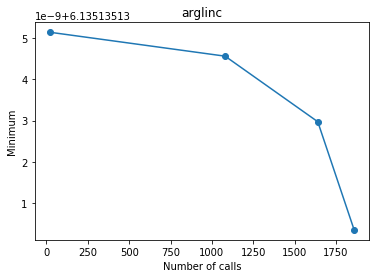

In [52]:
print(obj_lst,counter_lst)
plt.plot(counter_lst,obj_lst,'-o')
plt.xlabel("Number of calls")
plt.ylabel("Minimum")
plt.title(blackbox_name)
plt.savefig(blackbox_name+".png")